In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import tensorboard
import ot
from statsmodels.distributions.empirical_distribution import ECDF
import Prob_models as PM
import random
import scipy

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

2022-12-01 11:49:49.519358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Accelerating computation for threshold selection for dependency between radius and angle.

In [2]:
# Samples from R1
N_samples = 10000
A         = 2*tfd.Uniform().sample(N_samples)
X         = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(N_samples)
test_set  = A*X
test_set  =test_set.numpy()

2022-12-01 11:51:28.452780: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 11:51:28.457184: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-01 11:51:28.508739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:5e:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-12-01 11:51:28.508787: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-01 11:51:28.541321: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-01 11:51:28.541399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

In [3]:
#True dataset
def alphas_function(x):
    res = tf.convert_to_tensor([6. -3.*tf.minimum(1.,0.5/x), 6. -3.*tf.minimum(1.,0.5/x) , 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x)])
    return(tf.transpose(res))


alphas          = alphas_function(test_set)
angle_train_dep = tfd.Dirichlet(alphas).sample()

In [4]:
#Generated samples
checkpoint_path = '/home/nlafon/These/Extreme_VAE/tmp/sphere_radius1/normal_output/checkpoint'
import Prob_models as PM
vae_sphere = PM.Sphere_VAE()
vae_sphere.load_weights(checkpoint_path)
prior_samples = vae_sphere.encoder.prior.sample(10000)
print(test_set.shape)
angles_dist   = vae_sphere.decoder([prior_samples,tf.reshape(test_set,(10000,1))])
angle_train_dep   = angles_dist.sample()
print(angle_train_dep.shape)

(10000,)


2022-12-01 11:51:54.687028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(10000, 5)


In [9]:
Ind       = tf.argsort(test_set)
R1_sort   = test_set[Ind]
angle_dep = angle_train_dep.numpy()[Ind]

In [10]:
def distmat(X):
    r = tf.reduce_sum(X*X, 1)
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(X, tf.transpose(X)) + tf.transpose(r)
    return(tf.maximum(D,0))

def T(X,Y,n):
    MX = tf.math.sqrt(distmat(X))
    MY = tf.math.sqrt(distmat(Y))
    T1 = (1/n**2)*tf.reduce_sum(tf.math.multiply(MX,MY))
    T2 = (2/n**3)*tf.reduce_sum(tf.linalg.matmul(MX,MY))
    T3 = (1/n**4)*tf.reduce_sum(tf.tensordot(MX,MY,axes=0))
    return T1-T2+T3


In [11]:
nbq = 100
qmax=0.01
qmin=0.3
m=60
L=200

qk = np.arange(qmax,qmin,(qmin-qmax+0.001)/nbq)
nk = 500*qk
res=[]

for i in range(nbq):
    print(i)
    pvi = 0
    q = qk[i]
    indq =int((1-q)*10000)
    n = int(nk[i])
    r = R1_sort[indq]
    print(r)
    print(q)
    Rq = R1_sort[indq:]/r
    angle = angle_dep[indq:]
    Nq = 10000-indq
    start=datetime.now()
    for k in range(m):
        IndS = tf.random.shuffle(tf.range(start=0, limit=Nq, dtype=tf.int32))[:n]
        RqS_joint = tf.gather(Rq,IndS)
        RqS_joint = tf.reshape(RqS_joint,(n,1))
        angleS_joint = tf.gather(angle,IndS)
        T_emp = T(RqS_joint,angleS_joint,int(n))
        pvk=0
        for j in range(L):
            RqS_ind=tf.random.shuffle(Rq)[:int(n)]
            RqS_ind = tf.reshape(RqS_ind,(n,1))
            angleS_ind = tf.random.shuffle(angle)[:int(n)]
            T_ind = T(RqS_ind,angleS_ind,int(n))
            pvk+= T_emp.numpy()<(T_ind.numpy())
        pvk = pvk/L
        pvi+=pvk
    print(datetime.now()-start)
    pvi = pvi/m
    res.append(pvi)
    print(qk[i])
    print(pvi)

0
11.520438
0.01
0:00:24.272718
0.01
0.5073333333333335
1
9.532123
0.01291
0:00:24.221362
0.01291
0.44325000000000014
2
8.221483
0.01582
0:00:24.451351
0.01582
0.48550000000000004
3
7.134506
0.018729999999999997
0:00:24.442732
0.018729999999999997
0.5354166666666664
4
6.6180058
0.02164
0:00:24.281256
0.02164
0.5244166666666668
5
6.229108
0.024549999999999995
0:00:24.573283
0.024549999999999995
0.46908333333333346
6
5.8003364
0.02746
0:00:24.449010
0.02746
0.5110833333333332
7
5.362277
0.030369999999999994
0:00:24.638368
0.030369999999999994
0.5494166666666668
8
5.0651336
0.03328
0:00:24.369598
0.03328
0.5575833333333333
9
4.6548705
0.03618999999999999
0:00:24.500731
0.03618999999999999
0.5255833333333334
10
4.330626
0.039099999999999996
0:00:24.726406
0.039099999999999996
0.5205833333333332
11
4.1254816
0.04201
0:00:24.598439
0.04201
0.48433333333333317
12
3.8926275
0.044919999999999995
0:00:24.731802
0.044919999999999995
0.4760000000000001
13
3.7347574
0.04782999999999999
0:00:24.7020

## Optimal transport cost

In [5]:
import ot
def Wasserstein(s1,s2):
    M        = ot.dist(s1,s2)
    n1, n2   = s1.shape[0],s2.shape[0]
    a, b     = np.ones((n1,)) / n1, np.ones((n2,)) / n2
    return(ot.emd2(a,b,M))

In [6]:
checkpoint_path_sphere = '/home/nlafon/These/Extreme_VAE/tmp/sphere_radius1/normal_output/checkpoint'
checkpoint_path_rad    = '/home/nlafon/These/Extreme_VAE/tmp/radius1/Ext_VAE/Gamma_output9/Ext_VAE_custom_outputG_fig3'
N_samples              = 10000

import Prob_models as PM
#Sample radii
vae_rad     = PM.Ext_VAE()
vae_rad.load_weights(checkpoint_path_rad)
prior_rad   = vae_rad.encoder.prior.sample(N_samples)
samples_rad = vae_rad.decoder(prior_rad).sample()
samples_rad = tf.reshape(samples_rad,(N_samples,1))

#Sample angles
vae_sphere      = PM.Sphere_VAE()
vae_sphere.load_weights(checkpoint_path_sphere)
prior_samples   = vae_sphere.encoder.prior.sample(N_samples)

angles_dist     = vae_sphere.decoder([prior_samples,samples_rad])#
samples_angle   = angles_dist.sample()

#Overall samples
gen_samples     = samples_angle*samples_rad
real_samples    = angle_train_dep*tf.reshape(test_set,(N_samples,1))

In [7]:
Wasserstein(gen_samples.numpy(),real_samples.numpy())

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/nlafon/.conda/envs/tf-gpu/lib/python3.9/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


5.365620294566284

In [8]:
#Optimal transport upon threshold
Ind_true       = tf.argsort(test_set)
ordered_true   = real_samples.numpy()[Ind_true]
Ind_gen        = tf.argsort(samples_rad[:,0])
ordered_gen    = gen_samples.numpy()[Ind_gen]
print(ordered_gen.shape)

(10000, 5)


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is v

TypeError: unsupported operand type(s) for /: 'list' and 'list'

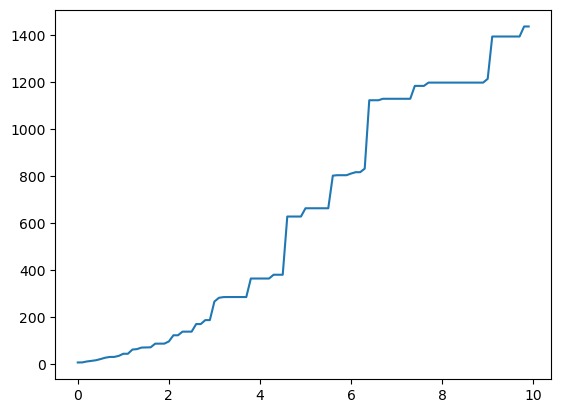

In [9]:
rad    = []
res    = []
r0     = 0
rmax   = 10

n_step = 100
step   = (rmax-r0)/n_step
r_curr = r0

for i in range(n_step):
    ind1     = np.where(ordered_true > r_curr)[0][0]
    ind2     = np.where(ordered_gen  > r_curr)[0][0]
    true_sup = ordered_true[ind1:,:]
    gen_sup  = ordered_gen[ind2:,:]
    res.append(Wasserstein(gen_sup,true_sup))
    rad.append(r_curr)
    r_curr  += step 
    
plt.plot(rad,res)
plt.plot((rad[1:],res[1:]/rad[1:]))

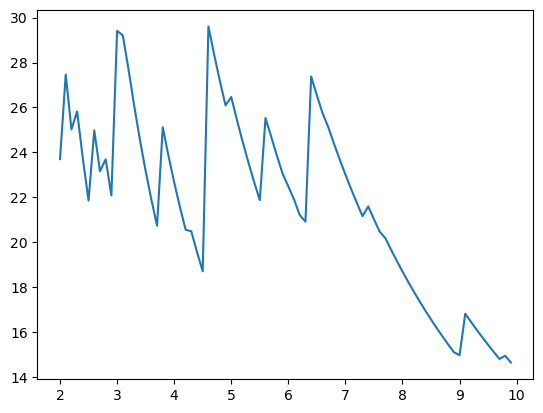

In [12]:
res2 = np.array(res[20:])/(np.array(rad[20:])**2)
r2 = np.array(rad[20:])
plt.plot(r2,res2)

In [14]:
print(res2)

[23.70003105 27.46059746 25.02091628 25.82019021 23.71333442 21.854209
 24.97652626 23.16067456 23.68815072 22.08265181 29.40781961 29.20982586
 27.69786343 26.06518961 24.5544909  23.17142162 21.9019996  20.73410627
 25.11557241 23.84410688 22.6668041  21.57459046 20.5594595  20.482639
 19.56218983 18.70241951 29.60394933 28.35760832 27.1883493  26.08994452
 26.46452405 25.43687433 24.46794013 23.55333219 22.68906383 21.87150748
 25.52637772 24.69361087 23.8494476  23.04784307 22.48155087 21.90523234
 21.2043105  20.91595767 27.37485844 26.53903436 25.74091372 25.11783692
 24.38450907 23.68283343 23.01101427 22.36738146 21.75038001 21.1585607
 21.59069989 21.01878624 20.46929928 20.17766826 19.66360867 19.1689465
 18.69271799 18.23401846 17.79199808 17.36585791 16.95484625 16.55825538
 16.17541849 15.80570685 15.44852726 15.10331967 14.96654404 16.81555651
 16.45198765 16.10008364 15.75935077 15.42932116 15.10955115 14.79961988
 14.94359164 14.6432256 ]
